In [1]:
%matplotlib inline

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import util
import time
import os

In [2]:
#tf.debugging.set_log_device_placement(True)
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
True
Num GPUs Available:  0


In [11]:
folder_path = 'datasets/kaggle_clement/split_files/'
train_file = 'train.csv'
valid_file = 'valid.csv'
test_file = 'test.csv'
save_file = 'test_pred.csv'

train=pd.read_csv(folder_path+train_file, header=0)
train_X,train_Y=(np.array(train["text"]),np.array(train["label"]))

valid=pd.read_csv(folder_path+valid_file, header=0)
valid_X,valid_Y=(np.array(valid["text"]),np.array(valid["label"]))

test=pd.read_csv(folder_path+test_file, header=0)
test_X,test_Y=(np.array(test["text"]),np.array(test["label"]))

In [4]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000000)
encoder.adapt(train_X)

In [5]:
model=tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary())+1000,
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [6]:
plotlosses = PlotLossesKerasTF()
checkpoint_path = "training_checkpoints/rnn_cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

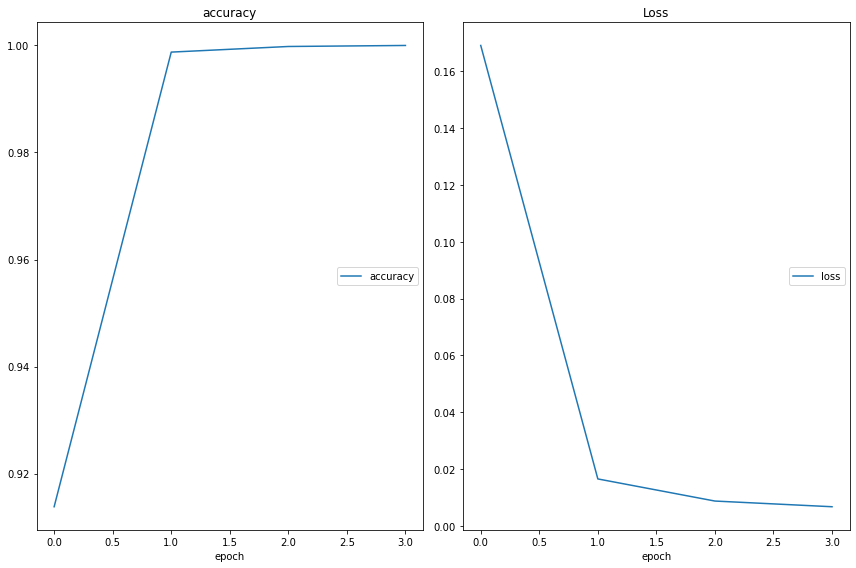

accuracy
	accuracy         	 (min:    0.914, max:    1.000, cur:    1.000)
Loss
	loss             	 (min:    0.007, max:    0.169, cur:    0.007)
 7616/31428 [======>.......................] - ETA: 1:04:17 - loss: 0.0067 - accuracy: 1.0000

KeyboardInterrupt: 

In [7]:
start_time = time.time()
history=model.fit(train_X,train_Y,epochs=10,validation_dataset=(valid_X,valid_Y),callbacks=[cp_callback,plotlosses],verbose=True, workers=1)
print("Execution time: " + str((time.time() - start_time)) + ' ms')

In [8]:
model.load_weights(checkpoint_path)

In [12]:
test_loss, test_acc = model.evaluate(test_X, test_Y, workers=1)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6735/6735 [==============================] - 88s 13ms/sample - loss: 0.0143 - accuracy: 0.9972
Test Loss: 0.014260629455193116
Test Accuracy: 0.9971789121627808
